In [4]:
# импортируем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# 1. hyperopt

In [5]:
# рассмотрим простой пример
best = fmin(
    fn=lambda x: x,
    space=hp.uniform('x', 0, 1),
    algo=tpe.suggest,
    max_evals=100)
# печатаем результат
print(best)

100%|█████| 100/100 [00:00<00:00, 353.34it/s, best loss: 5.223731910283455e-05]
{'x': 5.223731910283455e-05}


In [6]:
# еще один пример
best = fmin(
    fn=lambda x: (x-1)**2,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100,
    rstate=RandomState(123))
print(best)

100%|█████| 100/100 [00:00<00:00, 373.11it/s, best loss: 3.239117511790906e-06]
{'x': 1.001799754847692}


In [7]:
# найдем такое значение x, которое минимизирует 
# квадратичную функцию y(x)=x**2
fspace = {
    'x': hp.uniform('x', -5, 5)
}

def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, 
            space=fspace, 
            algo=tpe.suggest, 
            max_evals=1000, 
            trials=trials,
            rstate=RandomState(123))
print('best:', best)

100%|██| 1000/1000 [00:05<00:00, 171.10it/s, best loss: 1.7829880251661697e-08]
best: {'x': 0.00013352857466348428}


Text(0, 0.5, '$x$')

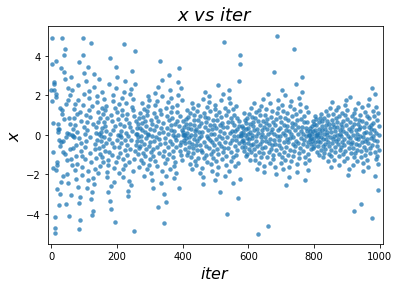

In [8]:
# визуализация значение аргумента/итерация
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['x'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $iter$', fontsize=18)
ax.set_xlabel('$iter$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16) 

Text(0, 0.5, '$val$')

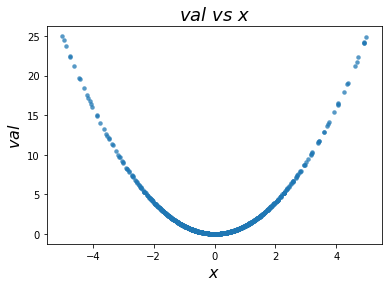

In [9]:
# визуализация значение функции/значение аргумента
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

In [10]:
# загружаем уже знакомые данные
data = pd.read_csv('data/StateFarm_missing.csv', encoding='cp1251', sep=';')

In [11]:
data.head()

,Customer Lifetime Value,Coverage,Education,EmploymentStatus,Gender,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Response
0,2763.519279,Basic,Bachelor,Employed,F,56274.0,NaN,32.0,5.0,NaN,1.0,No
1,NaN,NaN,Bachelor,Unemployed,F,0.0,NaN,13.0,42.0,NaN,NaN,No
2,NaN,NaN,NaN,Employed,F,48767.0,108.0,NaN,38.0,0.0,NaN,No
3,7645.861827,Basic,Bachelor,NaN,NaN,0.0,106.0,18.0,NaN,NaN,7.0,No
4,2813.692575,Basic,Bachelor,NaN,M,43836.0,73.0,12.0,NaN,NaN,1.0,No


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8293 entries, 0 to 8292
Data columns (total 12 columns):
Customer Lifetime Value          8289 non-null float64
Coverage                         8288 non-null object
Education                        8290 non-null object
EmploymentStatus                 8288 non-null object
Gender                           8289 non-null object
Income                           8291 non-null float64
Monthly Premium Auto             8282 non-null float64
Months Since Last Claim          8288 non-null float64
Months Since Policy Inception    8285 non-null float64
Number of Open Complaints        8287 non-null float64
Number of Policies               8288 non-null float64
Response                         8293 non-null object
dtypes: float64(7), object(5)
memory usage: 777.6+ KB


In [13]:
# разбиваем данные на обучающие и тестовые: получаем обучающий
# массив признаков, тестовый массив признаков, обучающий массив
# меток, тестовый массив меток
X_train, X_test, y_train, y_test = train_test_split(data.drop('Response', axis=1), 
                                                    data['Response'], 
                                                    test_size=0.3,
                                                    stratify=data['Response'],
                                                    random_state=42)

In [14]:
# создаем списки количественных 
# и категориальных столбцов
cat_columns = X_train.dtypes[X_train.dtypes == 'object'].index
num_columns = X_train.dtypes[X_train.dtypes != 'object'].index

# создаем конвейер для количественных переменных
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# создаем конвейер для категориальных переменных
cat_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# создаем список трехэлементных кортежей, в котором
# первый элемент кортежа - название конвейера с
# преобразованиями для определенного типа признаков
transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]

# передаем список трансформеров в ColumnTransformer
transformer = ColumnTransformer(transformers=transformers)

# задаем итоговый конвейер
pipe = Pipeline([('transform', transformer), 
                 ('logreg', LogisticRegression(solver='liblinear'))])

In [15]:
# пишем функцию, возвращающую правильность,
# усредненную по итогам перекрестной проверки
def hyperopt_objective(params):
    pipe.set_params(**params)
    return cross_val_score(pipe, X_train, y_train, cv=5).mean()

# создаем пространство значений гиперпараметров
space_hyperopt = {
    'logreg__C': hp.loguniform('logreg__C', np.log(0.01), np.log(100)),
    'transform__num__imputer__strategy': hp.choice(
        'transform__num__imputer__strategy', ['mean', 'median', 'constant']),
    'transform__cat__imputer__strategy': hp.choice(
        'transform__cat__imputer__strategy', ['most_frequent', 'constant'])
}

# пишем функцию, которая применяет ранее написанную
# нами функцию и возвращает результаты
def f(params):
    acc = hyperopt_objective(params)
    return {'loss': -acc, 'status': STATUS_OK}

# запускаем поиск
best = fmin(fn=f, 
            space=space_hyperopt,
            algo=tpe.suggest, 
            max_evals=50,
            rstate=RandomState(123))

# печатаем результаты
print('best:')
print(best)

100%|██████████| 50/50 [00:18<00:00,  2.82it/s, best loss: -0.8997418392655154]
best:
{'logreg__C': 0.015476036238528997, 'transform__cat__imputer__strategy': 1, 'transform__num__imputer__strategy': 1}


In [16]:
0.8975013504713217

0.8975013504713217

In [17]:
# записываем наилучшие значения гиперпараметров
best_params = space_eval(space_hyperopt, best)

# обучаем модель с наилучшими значениями
# гиперпараметров на обучающей выборке
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)

# вычисляем прогнозы на тестовой выборке
test_predict = pipe.predict(X_test)

# вычисляем правильность для тестовой выборки
acc = accuracy_score(y_test, test_predict)
acc

0.89991961414791

# 2. skopt (scikit-optimize)

In [18]:
# импортируем класс BayesSearchCV, функцию gp_minimize()
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Categorical, Integer

In [19]:
# найдем такое значение x, которое минимизирует 
# квадратичную функцию y(x)=(x-1)**2
best = gp_minimize(
    func=lambda x: (x[0] - 1) ** 2,
    dimensions=[Real(-2, 2)],
    n_calls=35,
    random_state=123)

# печатаем результат
print("наилучшее значение = %.4f" % best.fun)
print('x = %.4f' %best.x[0])

наилучшее значение = 0.0000
x = 1.0008


In [20]:
# создаем пространство значений гиперпараметров
space_skopt = {'logreg__C': Real(np.log10(1.01), np.log10(100), 'log_uniform'),
               'transform__num__imputer__strategy': Categorical(['mean', 'median', 'constant']),
               'transform__cat__imputer__strategy': Categorical(['most_frequent', 'constant'])}

In [21]:
# создаем экземпляр класса BayesSearchCV
opt = BayesSearchCV(pipe,
                    space_skopt,
                    n_iter=10,
                    random_state=42,
                    cv=5)
# запускаем поиск
opt.fit(X_train, y_train)
# печатаем наилучшее значение правильности
print('наилучшее значение: %s' % opt.best_score_)

наилучшее значение: 0.8997416020671835


In [22]:
# сохраняем результаты в датафрейм
results = pd.DataFrame(opt.cv_results_)
# превращаем в сводную таблицу
tbl = results.pivot_table(values=['mean_test_score'],    
                          index=['param_logreg__C', 
                                 'param_transform__cat__imputer__strategy',
                                 'param_transform__num__imputer__strategy'])
print(tbl)

                                                                                                 mean_test_score
param_logreg__C param_transform__cat__imputer__strategy param_transform__num__imputer__strategy                 
0.004419        constant                                constant                                        0.899742
0.053545        constant                                constant                                        0.899742
0.066265        constant                                mean                                            0.899397
0.121342        constant                                median                                          0.899397
0.190717        constant                                median                                          0.899397
0.390936        constant                                mean                                            0.898880
0.584464        most_frequent                           median                                  

In [23]:
# смотрим наилучшее значение
print(opt.best_score_)
# смотрим наилучшие гиперпараметры
print(opt.best_params_)
# смотрим качество наилучшей модели на тестовой выборке
print('значение на тестовой выборке: %s' % opt.score(X_test, y_test))

0.8997416020671835
OrderedDict([('logreg__C', 0.05354467320796604), ('transform__cat__imputer__strategy', 'constant'), ('transform__num__imputer__strategy', 'constant')])
значение на тестовой выборке: 0.89991961414791


In [24]:
# записываем наилучшие значения гиперпараметров
best_params_skopt = opt.best_params_

# обучаем модель с наилучшими значениями
# гиперпараметров на обучающей выборке
pipe.set_params(**best_params_skopt)
pipe.fit(X_train, y_train)

# вычисляем прогнозы на тестовой выборке
test_predict = pipe.predict(X_test)

# вычисляем правильность для тестовой выборки
acc = accuracy_score(y_test, test_predict)
acc

0.89991961414791

In [25]:
# импортируем функцию use_named_args()
from skopt.utils import use_named_args

In [26]:
# задаем пространство поиска в ином формате
space_skopt2 = [
    Real(np.log10(1.01), np.log10(100), name='logreg__C'),
    Categorical(['mean', 'median', 'constant'], name='transform__num__imputer__strategy'),
    Categorical(['most_frequent', 'constant'], name='transform__cat__imputer__strategy')
]

In [27]:
# пишем функцию, возвращающую правильность,
# усредненную по итогам перекрестной проверки
@use_named_args(space_skopt2)
def objective(**params):
    pipe.set_params(**params)
    return -np.mean(cross_val_score(pipe,
                                    X_train,
                                    y_train,
                                    cv=5,
                                    n_jobs=-1))

In [28]:
# осуществляем поиск
res = gp_minimize(objective, space_skopt2, n_calls=10, random_state=42)

In [29]:
# смотрим наилучшее значение
print('Наилучшее значение AUC: {:.4f}'.format(np.abs(res.fun)))
# смотрим наилучшие гиперпараметры
pd.DataFrame({'logreg__C': pd.Series(res.x[0]),
              'transform__num__imputer__strategy': pd.Series(res.x[1]),
              'transform__cat__imputer__strategy': pd.Series(res.x[2])})

Наилучшее значение AUC: 0.8997


,logreg__C,transform__num__imputer__strategy,transform__cat__imputer__strategy
0,0.050347,median,most_frequent


# 3. optuna

In [30]:
# импортируем библиотеку optuna
import optuna
# импортируем класс RandomSampler для того, чтобы задать стартовое 
# значение генератора псевдослучайных чисел
from optuna.samplers import RandomSampler
# импортируем класс OptunaSearchCV
from optuna.integration import OptunaSearchCV
# импортируем классы, задающие форму распределения значений гиперпараметров
from optuna.distributions import LogUniformDistribution, CategoricalDistribution, UniformDistribution
# импортируем функции для визуализации
from optuna.visualization import plot_slice, plot_contour, plot_optimization_history

In [31]:
# задаем оптимизируемую функцию
def objective(trial):
    x = trial.suggest_uniform('x', -10, 10)
    return (x - 2) ** 2

In [32]:
# задаем стартовое значение генератора псевдослучайных чисел
sampler = RandomSampler(seed=10)
# создаем объект study (сессию оптимизации)
study = optuna.create_study(sampler=sampler)
# выполняем оптимизацию
study.optimize(objective, n_trials=100)

[I 2020-05-06 15:09:35,647] Finished trial#0 with value: 11.740305123732652 with parameters: {'x': 5.426412865334919}. Best is trial#0 with value: 11.740305123732652.
[I 2020-05-06 15:09:35,801] Finished trial#1 with value: 134.21132166837336 with parameters: {'x': -9.58496101281197}. Best is trial#0 with value: 11.740305123732652.
[I 2020-05-06 15:09:35,953] Finished trial#2 with value: 0.45288148546152784 with parameters: {'x': 2.672964698525508}. Best is trial#2 with value: 0.45288148546152784.
[I 2020-05-06 15:09:36,103] Finished trial#3 with value: 8.857038183425992 with parameters: {'x': 4.976077650772236}. Best is trial#2 with value: 0.45288148546152784.
[I 2020-05-06 15:09:36,252] Finished trial#4 with value: 4.120330620698611 with parameters: {'x': -0.02985975394819107}. Best is trial#2 with value: 0.45288148546152784.
[I 2020-05-06 15:09:36,402] Finished trial#5 with value: 56.311022881961755 with parameters: {'x': -5.504067089383047}. Best is trial#2 with value: 0.4528814854

[I 2020-05-06 15:09:42,799] Finished trial#47 with value: 32.24796977023997 with parameters: {'x': 7.678729591223725}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:42,954] Finished trial#48 with value: 30.13754438621382 with parameters: {'x': -3.4897672433550238}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:43,108] Finished trial#49 with value: 75.68446769483133 with parameters: {'x': -6.69968204561703}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:43,258] Finished trial#50 with value: 17.217645846949875 with parameters: {'x': -2.1494151210682544}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:43,407] Finished trial#51 with value: 102.63295685690515 with parameters: {'x': -8.130792508826994}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:43,546] Finished trial#52 with value: 19.555084771000345 with parameters: {'x': 6.422113156738568}. Best is trial

[I 2020-05-06 15:09:50,118] Finished trial#94 with value: 27.10080266546033 with parameters: {'x': -3.2058431272427264}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:50,280] Finished trial#95 with value: 4.405915951858926 with parameters: {'x': -0.09902738235091313}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:50,440] Finished trial#96 with value: 56.87594954495065 with parameters: {'x': 9.541614518453635}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:50,589] Finished trial#97 with value: 10.141189934705443 with parameters: {'x': -1.1845235019866696}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:50,754] Finished trial#98 with value: 31.748084853080346 with parameters: {'x': -3.634543890420976}. Best is trial#29 with value: 0.00043176967072578425.
[I 2020-05-06 15:09:50,909] Finished trial#99 with value: 2.5730093898695916 with parameters: {'x': 0.39593971750760204}. Best is 

In [33]:
# выведем значение 𝑥, при котором было найдено 
# наилучшее значение целевой функции
print(study.best_params)
# выведем наилучшее значение целевой функции
print(study.best_value)
# выведем номер итерации, на которой было найдено 
# наилучшее значение целевой функции
print(study.best_trial)

{'x': 2.0207790680908886}
0.00043176967072578425
FrozenTrial(number=29, value=0.00043176967072578425, datetime_start=datetime.datetime(2020, 5, 6, 15, 9, 39, 903675), datetime_complete=datetime.datetime(2020, 5, 6, 15, 9, 40, 49684), params={'x': 2.0207790680908886}, distributions={'x': UniformDistribution(high=10, low=-10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=29, state=TrialState.COMPLETE)


In [34]:
# выводим результаты в виде датафрейма pandas
results_df = study.trials_dataframe(attrs=('number', 'value', 'params'))
results_df

,number,value,params_x
0,0,11.740305,5.426413
1,1,134.211322,-9.584961
2,2,0.452881,2.672965
3,3,8.857038,4.976078
4,4,4.120331,-0.029860
...,...,...,...
95,95,4.405916,-0.099027
96,96,56.875950,9.541615
97,97,10.141190,-1.184524
98,98,31.748085,-3.634544


In [35]:
# немного модифицируем конвейер
pipe = Pipeline([('transform', transformer), 
                 ('logreg', LogisticRegression(max_iter=500))])

In [36]:
# пишем функцию, которую будем оптимизировать
def objective(trial):
    # задаем пространство поиска
    params = {
        'logreg__C': trial.suggest_loguniform('logreg__C', np.log10(1.01), np.log10(100)),
        'logreg__solver': trial.suggest_categorical('logreg__solver', ['lbfgs', 'liblinear'])
    }
    pipe.set_params(**params)
    return np.mean(cross_val_score(pipe, X_train, y_train, cv=5))

In [37]:
# задаем новое стартовое значение генератора псевдослучайных чисел
sampl = RandomSampler(seed=10)
# создаем задачу оптимизации
study = optuna.create_study(sampler=sampl, direction='maximize')
# отключаем вывод результатов оптимизации в режиме реального времени
optuna.logging.disable_default_handler()
# выполняем оптимизацию
study.optimize(objective, n_trials=100)

In [38]:
# печатаем количество итераций
print('Количество итераций: {}'.format(len(study.trials)))
# печатаем итерацию с наилучшим значением оптимизируемой метрики и
# наилучшими значениями гиперпараметров
print('Итерация с наилучшим значением метрики:')
trial = study.best_trial
print('  Значение: {}'.format(trial.value))
print('  Гиперпараметры: ')
for key, value in trial.params.items():
    print('  {}: {}'.format(key, value))

Количество итераций: 100
Итерация с наилучшим значением метрики:
  Значение: 0.8997418392655154
  Гиперпараметры: 
  logreg__C: 0.014572706202916015
  logreg__solver: lbfgs


In [39]:
# обучаем модель с наилучшими значениями
# гиперпараметров на обучающей выборке
pipe.set_params(**study.best_params)
pipe.fit(X_train, y_train)

# вычисляем прогнозы на тестовой выборке
test_predict = pipe.predict(X_test)

# вычисляем правильность для тестовой выборки
acc = accuracy_score(y_test, test_predict)
acc

0.89991961414791

In [40]:
# задаем пространство поиска в немного ином формате
param_distributions = {'logreg__C': LogUniformDistribution(np.log10(1.01), np.log10(100)),
                       'logreg__solver': CategoricalDistribution(['lbfgs', 'liblinear'])}

# создаем экземпляр класса OptunaSearchCV
optuna_search = OptunaSearchCV(
    pipe,
    param_distributions,
    random_state=42,
    n_trials=100,
    cv=5)
# выполняем оптимизацию
optuna_search.fit(X_train, y_train)
# печатаем наилучшие значения гиперпараметров
print(optuna_search.best_params_)
# печатаем наилучшее значение
print(optuna_search.best_score_)

{'logreg__C': 0.07040211868893413, 'logreg__solver': 'lbfgs'}
0.8997418392655154


In [41]:
# модифицируем конвейер для работы с классом LGBMClassifier
lgbm_pipe = Pipeline([('transform', transformer), 
                      ('lgboost', LGBMClassifier(random_state=42, max_depth=6))])

In [42]:
# пишем оптимизируемую функцию
def lgbm_objective(trial):
    params = {
        'lgboost__learning_rate': trial.suggest_loguniform('lgboost__learning_rate', 0.005, 0.5),
        'lgboost__n_estimators': trial.suggest_int('lgboost__n_estimators', 50, 300), 
    }
    lgbm_pipe.set_params(**params)
    return np.mean(cross_val_score(lgbm_pipe, X_train, y_train, cv=5))

In [43]:
# выполняем оптимизацию
study.optimize(lgbm_objective, n_trials=50)

In [44]:
# печатаем результаты
print(study.best_params)
print(study.best_value)

{'lgboost__learning_rate': 0.35693386297259777, 'lgboost__n_estimators': 237}
0.9362607669000361


In [45]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

In [46]:
# печатаем график значений функции для значений гиперпараметра
plot_slice(study, params=['lgboost__learning_rate', 
                          'lgboost__n_estimators'])

In [47]:
# печатаем график линии уровня функции
plot_contour(study, params=['lgboost__learning_rate', 
                            'lgboost__n_estimators'])

In [48]:
# печатаем график истории оптимизации
plot_optimization_history(study)

In [49]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']